In [1]:
suppressMessages(library(SPEI))
source("../../wwa_model-fitting.R")

In [99]:
mu0 <- 5
alpha <- 10
sigma0 <- 2

set.seed(42)
df <- read.table("gmst.dat", col.names = c("year", "gmst"))
df <- df[df$year <= 2024,]
df$mean <- mu0 * exp((alpha * df$gmst) / mu0)
df$scale <- sigma0 * exp((alpha * df$gmst) / mu0)

df$pr <- df$mean + rgamma(nrow(df), shape = 2) # add some Gamma noise (NB. this has constant variance, should increase with mean)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# for nonstationary variance as well as mean
# m = a/b
# v = a/b^2
b <- sqrt(df$mean / df$scale^2)
a <- b * df$mean
df$pr <- rgamma(nrow(df), shape = a, rate = b) # nonstationary samples
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

spi_est <- spi(ts(df$pr, start = c(1879,1), end = c(2024, 1), deltat = 1), scale = 1, ref.start = c(1980,1), ref.end = c(2010, 1))
df$spi <- c(spi_est$fitted)

mdl_shift <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm_1 = "gmst")
mdl_scale <- fit_ns("norm", type = "fixeddisp", data = df, varnm = "spi", covnm_1 = "gmst")

pr_shift <- fit_ns("norm", type = "shift", data = df, varnm = "pr", covnm_1 = "gmst")
pr_scale <- fit_ns("norm", type = "fixeddisp", data = df, varnm = "pr", covnm_1 = "gmst")

In [100]:
# scale fit is better for the unnormalised data
aic(pr_shift)
aic(pr_scale)

[1] 800.3619

[1] 660.9134

In [101]:
# shift fit is a better fit to the normalised data according to AIC
aic(mdl_shift)
aic(mdl_scale)

[1] 351.6358

[1] 583.6126

In [106]:
prep_window(c(1,2))

png("shift-vs-scale-for-normalised-data.png", height = 480, width = 480 * 2); par(cex.main = 1.4); {
    par(mfrow = c(1,2))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot(df$gmst, df$pr, main = "Original data", xlab = "GMST", ylab = "Precip")

    lines(df$gmst, ns_pars(fit_ns("norm", type = "shift", data = df, varnm = "pr", covnm_1 = "gmst"))$loc, col = "blue", lwd = 2)
    lines(df$gmst, ns_pars(fit_ns("norm", type = "fixeddisp", data = df, varnm = "pr", covnm_1 = "gmst"))$loc, col = "red", lwd = 2)

    legend("topleft", c(paste0("Shift fit (AIC ",round(aic(pr_shift)),")"), 
                        paste0("Scale fit (AIC ",round(aic(pr_scale)),")")), col = c("blue", "red"), lty = 1, lwd = 2)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot(df$gmst, df$spi, main = "Normalised data", xlab = "GMST", ylab = "SPI")

    lines(df$gmst, ns_pars(mdl_shift)$loc, col = "blue", lwd = 2)
    lines(df$gmst, ns_pars(mdl_scale)$loc, col = "red", lwd = 2)
    legend("topleft", c(paste0("Shift fit (AIC ",round(aic(mdl_shift)),")"),
                        paste0("Scale fit (AIC ",round(aic(mdl_scale)),")")), col = c("blue", "red"), lty = 1, lwd = 2)
}; dev.off()


png 
  2

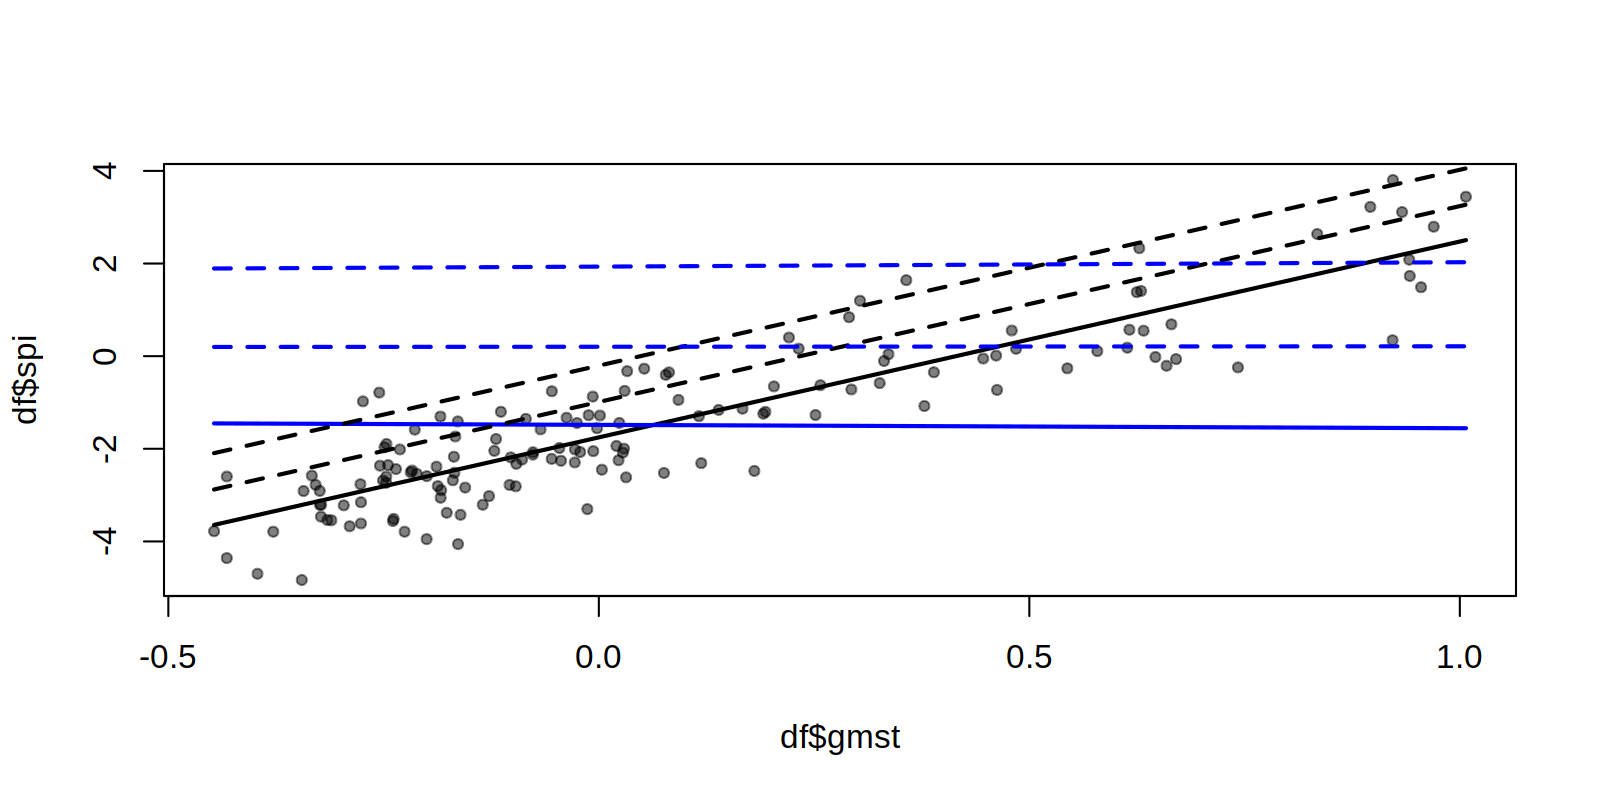

In [90]:
prep_window(c(1,2)); par(mfrow = c(1,1))

plot(df$gmst, df$spi, pch = 20, col = adjustcolor("black", alpha = 0.5))
lines(df$gmst, ns_pars(mdl_shift)$loc, lwd = 2)
lines(df$gmst, ns_pars(mdl_scale)$loc, lwd = 2, col = "blue")

lines(sort(df$gmst), eff_return_level(mdl_shift, 6)[order(df$gmst)], lwd = 2, lty = 2)
lines(sort(df$gmst), eff_return_level(mdl_shift, 40)[order(df$gmst)], lwd = 2, lty = 2)

lines(sort(df$gmst), eff_return_level(mdl_scale, 6)[order(df$gmst)], lwd = 2, lty = 2, col = "blue")
lines(sort(df$gmst), eff_return_level(mdl_scale, 40)[order(df$gmst)], lwd = 2, lty = 2, col = "blue")

In [91]:
# what do the standardised mean values look like?
# (almost certainly a terrible idea but let's see what this comes up with)
spi_mean <- spi(ts(df$mean, start = c(1879,1), end = c(2024, 1), deltat = 1), scale = 1, ref.start = c(1980,1), ref.end = c(2010, 1))
df$mean_spi <- c(spi_mean$fitted)

mmdl_shift <- fit_ns("norm", type = "shift", data = df, varnm = "mean_spi", covnm_1 = "gmst")
mmdl_scale <- fit_ns("norm", type = "fixeddisp", data = df, varnm = "mean_spi", covnm_1 = "gmst")

In [96]:
mean_shift <- fit_ns("norm", type = "shift", data = df, varnm = "mean", covnm_1 = "gmst")
# mean_scale <- fit_ns("norm", type = "fixeddisp", data = df, varnm = "mean", covnm_1 = "gmst") # parameter estimation fails here

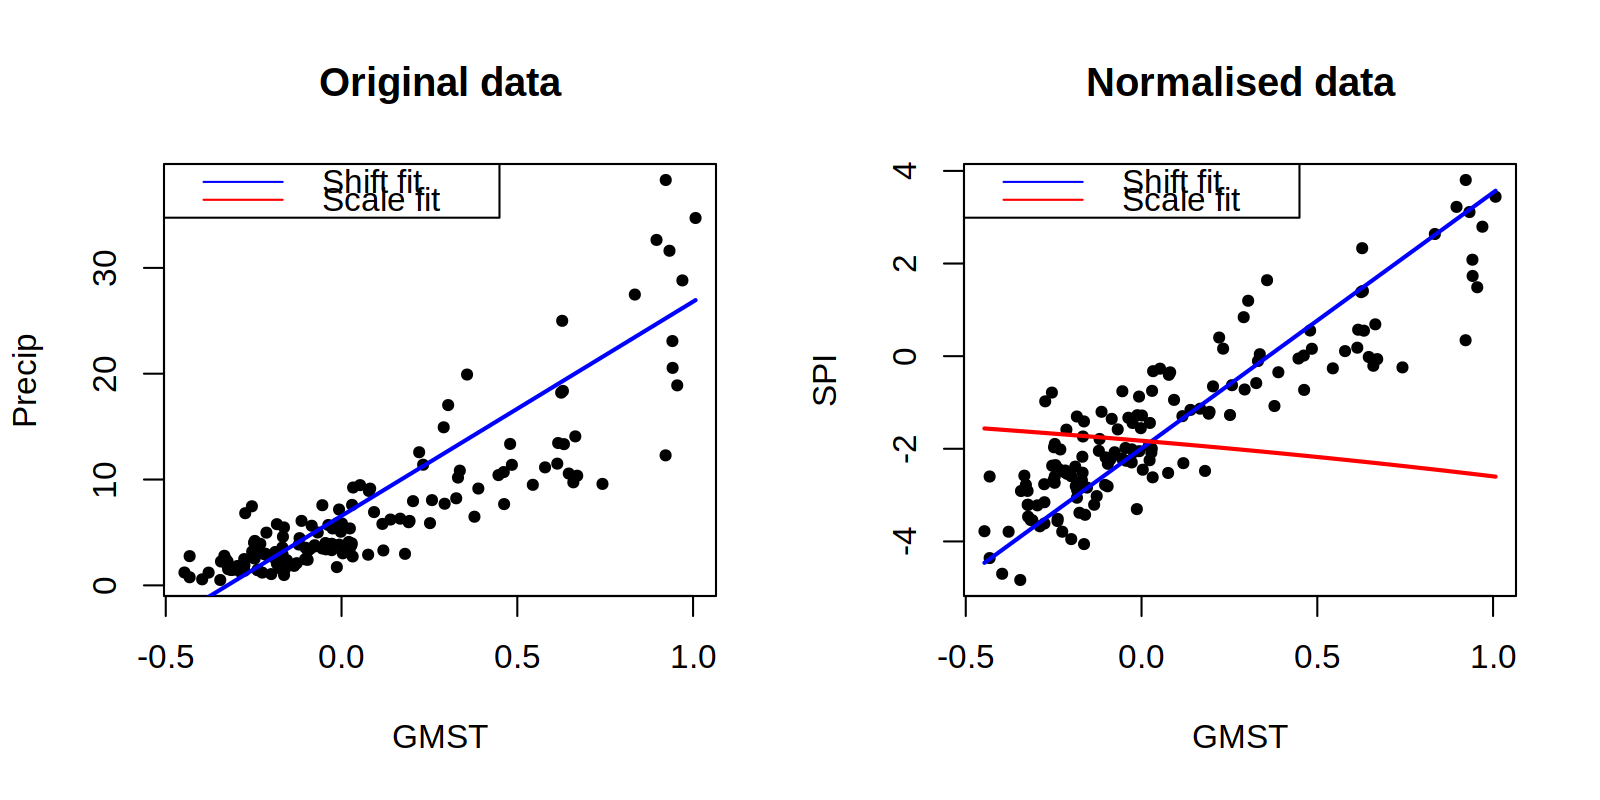

In [97]:
prep_window(c(1,2))
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(df$gmst, df$pr, main = "Original data", xlab = "GMST", ylab = "Precip")

lines(df$gmst, ns_pars(mean_shift)$loc, col = "blue", lwd = 2)
# lines(df$gmst, ns_pars(mean_scale)$loc, col = "red", lwd = 2)

legend("topleft", c("Shift fit", "Scale fit"), col = c("blue", "red"), lty = 1)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(df$gmst, df$spi, main = "Normalised data", xlab = "GMST", ylab = "SPI")

lines(df$gmst, ns_pars(mmdl_shift)$loc, col = "blue", lwd = 2)
lines(df$gmst, ns_pars(mmdl_scale)$loc, col = "red", lwd = 2)
legend("topleft", c("Shift fit", "Scale fit"), col = c("blue", "red"), lty = 1)
